# Navier-Stokes chanel with obstacle

We want to solve the Navier-Stokes incompressible equations along a 2D channel. 

The equations are:

$$
\rho(\partial_t u_i + u^j\partial_j u_i) = \partial^j \sigma_{ij}(u,p) + f_i
$$

where,

$$\sigma_{ij} := 2\mu \epsilon_{ij} - e_{ij}p \;\;\;\;\;\;\;\; \epsilon_{ij} = \partial_{(i} u_{j)}$$,

$$\partial^i u_i = 0$$

As boundary condition we shall say that along the chanel there are non-slip boundary conditions ($u=0$).
At the left entrance of the chanel there will be given a velocity and at the end an outflow condition we shall take as the boundary condition that the velocity has vanishing derivative along the chanel and that the pressure there vanish. (at least this seems to be the condition imposed in the code)

In [1]:
"""This demo program solves the incompressible Navier-Stokes equations
on an L-shaped domain using Chorin's splitting method."""

# Is is based in: 
#
# Copyright (C) 2010-2011 Anders Logg
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Modified by Mikael Mortensen 2011
#
# First added:  2010-08-30
# Last changed: 2011-06-30
#
# Modified by Oscar Reula

# Begin demo

%matplotlib inline
import matplotlib.pyplot as plt
from dolfin import *
from mshr import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

We set the evolution parameters:

In [2]:
#some cases:

chann = False # the chanel without obstacle
obst1 = True # this is more general than 2, but seems to be slow. This also gives incomming boundary condition for the pressure.
obst2 = False # this gives a velocity field for incomming condition.
jet = False # jet
noslip = False # when false is a non-penetrating condition (works with obst1 because we need to mark boundaries)
total_slip = True # non-penetrating also at cylinder. Only of obs1

In [3]:
# Set parameter values
#dt = 0.005
#T = 3.0 #3
#nu = 0.01

T = 6.0            # final time
#num_steps = 6000   # number of time steps for 128 T=3 case2
num_steps = 12000   # number of time steps for 128 T=6 case2
#num_steps = 3000   # number of time steps for 64 T=3 case3
#num_steps = 24000   # number of time steps for 64 T=6 case3
dt = T / num_steps # time step size

# Intervals where data is saved
#mod = 30 # for 64
#mod = 60 # for 128
#mod = 120 # for 128 T=6
#mod = 240 # for 256 T=3
mod = 480

# dynamic viscosity
if chann:
    mu =1.
elif obst2:
    mu = 0.001
else:
    mu = 0.001
    
    
rho = 1    

Create the meshes and plot them:

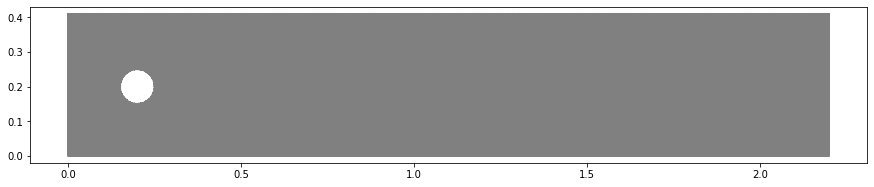

In [4]:
# Load mesh from file
#mesh = Mesh("../lshape.xml.gz")
# Create mesh

if chann:
    length = 1.
    width = 1.
    
    channel = Rectangle(Point(0, 0), Point(length, width))
    domain = channel
    
elif jet:
    length = 2.
    width = 1.
    
    mesh = RectangleMesh(Point(0, 0), Point(length, width), 256, 256);
    #channel = Rectangle(Point(0, 0), Point(length, width))
    #domain = channel
    
else:
    length = 2.2
    width = 0.41
    center_x = 0.2
    center_y = 0.2 #width / 2.
    radious = 0.05 #width / 4.
    
    channel = Rectangle(Point(0, 0), Point(length, width))
    cylinder = Circle(Point(center_x, center_y), radious)
    domain = channel - cylinder


mesh = generate_mesh(domain, 256)

# Plot mesh
plt.figure(figsize=(15,20))
plot(mesh)

We now create the function spaces, notice the difference between the function spaces for the velocity and pressure spaces, not only on the geometrical character but also on the degree. 

In [5]:
# Create files for storing solution
#ufile = File("results/velocity_64jet.pvd")
#pfile = File("results/pressure_64jet.pvd")
#vfile = File("results/vorticity_64jet.pvd")
#dfile = File("results/divergence_64jet.pvd")
#ufile = File("results/velocity_256jet_u.pvd")
#pfile = File("results/pressure_256jet_u.pvd")
#vfile = File("results/vorticity_256jet.pvd")
#dfile = File("results/divergence_256jet.pvd")

ufile = File("results/velocity_256ctns.pvd")
pfile = File("results/pressure_256ctns.pvd")
vfile = File("results/vorticity_256ctns.pvd")
dfile = File("results/divergence_256ctns.pvd")

#ufile = File("results/velocity_128cn.pvd")
#pfile = File("results/pressure_128cn.pvd")
#vfile = File("results/vorticity_128cn.pvd")
#dfile = File("results/divergence_128cn.pvd")

#ufile = File("results/velocity_128cll.pvd")
#pfile = File("results/pressure_128cll.pvd")
#vfile = File("results/vorticity_128cll.pvd")
#dfile = File("results/divergence_128cll.pvd")
#ufile = File("results/velocity_256cll.pvd")  # c mu = 0.001 cl 0.0001, cll 0.00001
#pfile = File("results/pressure_256cll.pvd")
#vfile = File("results/vorticity_256cll.pvd")
#dfile = File("results/divergence_256c.pvd")

In [6]:
# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
#V = FunctionSpace(mesh, "N1curl", 2) # does not seems to work
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u1  = Function(V)
p_n = Function(Q)
p1  = Function(Q)

Some expressions we shall use at the variational stage

In [7]:
# Define expressions used in variational forms
U  = 0.5*(u_n + u)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

We define $\epsilon_{ij}(u) := \partial_{(i} v_{j)}$ and $\sigma_{ij} := 2 \mu \epsilon_{ij} - p \delta_{ij}$

In [8]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

We are now in condition to set the boundaries.

In [9]:

tol = 1.E-4


if chann or jet:
    
    # Define boundaries
    inflow   = 'near(x[0], 0)'
    if case0: 
        outflow  = 'near(x[0], 1.0)'
    if case3:
        outflow  = 'near(x[0], 2.0)'
    walls    = 'near(x[1], 0) || near(x[1], 1.0)'

    # Define inflow profile
    if chann:
        inflow_profile = ('4.0*x[1]*(1.0 - x[1])', '0.0')

    if jet: 
        inflow_profile = ('(x[1] < 0.45 || x[1] > 0.55)? 0.0: 1.0', '0.0')
        #inflow_profile = ('exp(-(x[1]-0.5)*(x[1]-0.5)*(x[1]-0.5)*(x[1]-0.5))', '0.0')
        #inflow_profile = ('4.0*x[1]*(1.0 - x[1])', '0.0')
        
    # Define boundary conditions
    bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
    if noslip:
        bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
    bcp_outflow = DirichletBC(Q, Constant(0), outflow)
    bcp_inflow = DirichletBC(Q, Constant(8), inflow)
    if nonslip:
        bcu = [bcu_inflow, bcu_walls]
    else:
        bcu = bcu_inflow
    bcp = [bcp_outflow]

if obst1:

    # boundary_markers = FacetFunction('size_t', mesh)  # Esto fue actualizado
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)


    class outer_top_botom(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[1], 0, tol) or near(x[1],width, tol) 
    outer_tb = outer_top_botom()
    outer_tb.mark(boundary_markers, 0)

    class outer_left(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[0], 0, tol) 
    outer_l = outer_left()
    outer_l.mark(boundary_markers, 1)

    class outer_right(SubDomain):
        def inside(self, x, on_boundary):
            return  on_boundary and near(x[0], length, tol) 
    outer_r = outer_right()
    outer_r.mark(boundary_markers, 2)

    class cyl(SubDomain):
        def inside(self, x, on_boundary):
            #return  on_boundary and near((x[0]-center_x)**2 + (x[1]-center_y)**2, radious**2, tol) 
            return  on_boundary and (x[0] > (center_x - radious - tol)) and (x[0] < (center_x + radious + tol))\
            and  (x[1] > (center_y - radious - tol)) and  (x[1] < (center_y + radious + tol))
    cyl = cyl()
    cyl.mark(boundary_markers, 3)
    
    # Define time-dependent pressure boundary condition
    #p_in = Expression("sin(3.0*t)", t=0.0, degree=2)
    p_in = Constant(1.)
    
    # Define inflow profile
    #inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')
    inflow_profile = ('1', '0')

    # Define boundary conditions
    noslip_wall  = DirichletBC(V, (0, 0), outer_tb)
    bcp_inflow  = DirichletBC(Q, p_in, outer_l)
    bcu_inflow  = DirichletBC(V, Expression(inflow_profile, degree=2), outer_l)
    bcp_outflow = DirichletBC(Q, Constant(0), outer_r)
    noslip_cyl = DirichletBC(V, (0, 0), cyl)
    if noslip:
        bcu = [noslip_wall, noslip_cyl, bcu_inflow]
    if total_slip:
        bcu = [bcu_inflow]  
    else: 
        bcu = [noslip_cyl, bcu_inflow]
    bcp = [bcp_inflow, bcp_outflow]

    
if obst2:
    # Define boundaries
    inflow   = 'near(x[0], 0)'
    outflow  = 'near(x[0], 2.2)'
    walls    = 'near(x[1], 0) || near(x[1], 0.41)'
    cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

    # Define inflow profile
    inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

    # Define boundary conditions
    bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
    if noslip:
        bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
    bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
    bcp_outflow = DirichletBC(Q, Constant(0), outflow)
    if noslip:
        bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
    else: 
        bcu = [bcu_inflow, bcu_cylinder]
    bcp = [bcp_outflow]

ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
#n = FacetNormal(mesh.leaf_node())
n = FacetNormal(mesh)

The first step it to solve for $u^{\star}$, a first approximation to the value of $u$ at $t+dt$:

$$ < \rho(u^{\star} - u^n)/dt, v>_{\Omega} + <\rho u^n \cdot \nabla u^n, v>_{\Omega} + <\sigma(u^{n+\frac12},p^n), \epsilon(v)>_{\Omega} + <p^n n, v>_{\partial\Omega} - <\mu \nabla(u^{n+\frac12})\cdot n, v>_{\partial\Omega} = <f^n,v>_{\Omega},
$$

where $u^{n+\frac12} := \frac12(u^n + u^{\star})$

In [10]:
# Define variational problem for step 1

if noslip: 
    tau = 0 
else: 
    tau = 1
    
if total_slip:
    tau = 1
    tau_cyl = 1
    
# the tau term is a boundary condition for the normal component of the velocity at the external border 

F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   + tau * dot(dot(u,n)*n,v)*ds(0) \
   + tau_cyl * dot(dot(u,n)*n,v)*ds(3) \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

Next we find $p$ so that the time derivative of $u$ is divergence free:

In [11]:
# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u1)*q*dx

Finally we correct the value of $u$ with the new pressure:

In [12]:
# Define variational problem for step 3
a3 = dot(u, v)*dx - tau * dot(dot(u,n)*n,v)*ds(0)  - tau_cyl * dot(dot(u,n)*n,v)*ds(3) 
L3 = dot(u1, v)*dx - k*dot(nabla_grad(p1 - p_n), v)*dx 

Here we assemble all the numerical matrices in the appropriate format and apply boundary conditions.

In [13]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

We choose the solver for the matrix inversion:

In [14]:
# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Use nonzero guesses - essential for CG with non-symmetric BC
parameters['krylov_solver']['nonzero_initial_guess'] = True

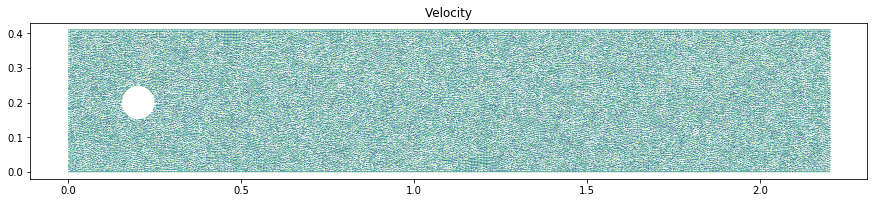

In [15]:
# initial data

#u_n = Expression(('1.0','0.0'), degree=2)
u_i = project(Expression(('1.0','0.0'), degree=2), V)
p_i = project(Expression('1.0', degree=1), Q)
              
plt.figure(figsize=(15,20))
plot(u_i, title="Velocity")
#vfile << u_n

In [16]:
# assign initial conditions

u_n.assign(u_i)
p_n.assign(p_i)
 
# send them to memory


# Time-stepping



t = 0
for m in range(num_steps):


    # Update pressure boundary condition
    if obst1:
        p_in.t = t

    # Compute tentative velocity step
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "bicgstab", "default")

    # Pressure correction
    b2 = assemble(L2)
    [bc.apply(A2, b2) for bc in bcp]
    [bc.apply(p1.vector()) for bc in bcp]
    solve(A2, p1.vector(), b2, "bicgstab", prec)

    # Velocity correction
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "bicgstab", "default")

    # Save to file
        
    if (m%mod==0): 
        
        ufile << u1
        pfile << p1



    # Move to next time step
    u_n.assign(u1)
    p_n.assign(p1)
    
    # Update current time
    t += dt


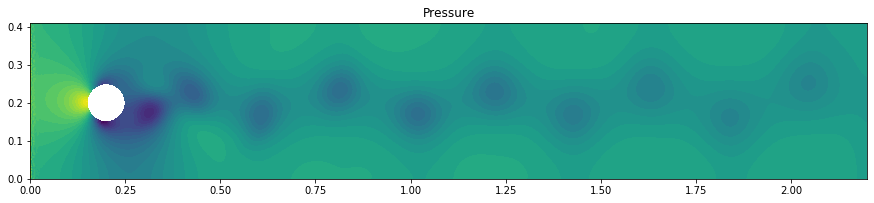

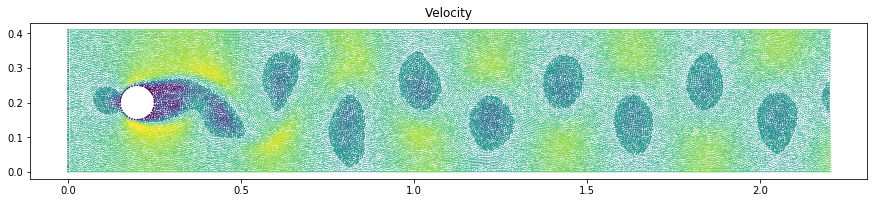

In [17]:
# Plot solution
plt.figure(figsize=(15,20))
plot(p1, title="Pressure")

plt.figure(figsize=(15,20))
plot(u1, title="Velocity")
#plot(mesh)

#plt.show()

#ufile.close()
#pfile.close()

We now compute the vorticity, namely $\nabla \wedge u$. Since we are in two dimensions this is a scalar (z-component of a vector).

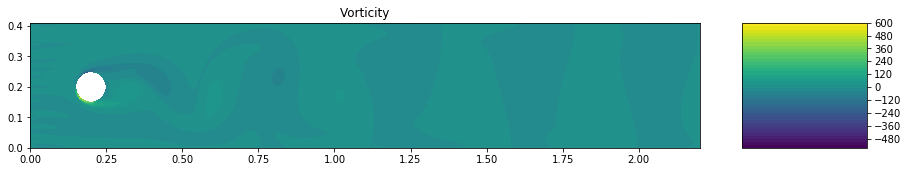

In [18]:
vor = Function(Q)
vor = curl(u1)

fig_vor = plt.figure(figsize=(15,20))
Vor = plot(vor, title="Vorticity")
fig_vor.colorbar(Vor, shrink=0.5, aspect=1)
#fig_vor.pcolor(Vor, cmap='RdBu',vmin = -10, vmax = 10)



vfile << project(vor,Q)

#plot(mesh)


#b = project(curl(u_n),V)



Finally we compute the divergence, $\nabla \cdot u$, which should vanish for the case.  

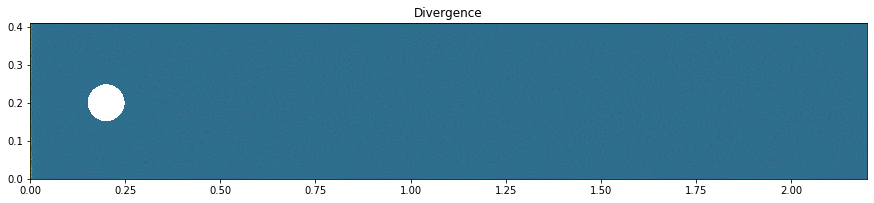

In [22]:
divergence = Function(Q)
divergence = div(u1)

fig_div = plt.figure(figsize=(15,20))
Div = plot(divergence, title="Divergence")
fig_vor.colorbar(Vor, shrink=0.5, aspect=1)
#fig_vor.pcolor(Vor, cmap='RdBu',vmin = -10, vmax = 10)



dfile << project(divergence,Q)


Para tener una idea relativa del error en la divergencia calculamos el cociente de las normas L2 con el rotor.
$$ ratio = \frac{\sqrt{\int|\nabla \cdot u|^2\;d^3x}}{\sqrt{\int|\nabla \wedge u|^2 \; d^3x}}$$

In [20]:
VOR_L2 = sqrt(assemble(vor*vor*dx))
DIV_L2 = sqrt(assemble(divergence*divergence*dx))
ratio = DIV_L2/VOR_L2

In [21]:
ratio


0.531458707007449

ratio (128) = 0.0467492797549064 nonslip

ratio (64) = 0.34634063688463096 slip and initial velocity/pressure

ratio (128) = 0.5005675466052402 full slip 

ratio (256) = 0.531458707007449 full slip ???